<a href="https://colab.research.google.com/github/ZhyShe/18ma573ZhiyuanShe/blob/master/src/hw4_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The objective is to get familiar with model calibration.
- download call today's option prices of your favrite stock with maturity $T_1$ and several near the money strikes $(K_1, \ldots, K_n)$.
- compute IV with your bsm price engine for each option price. You are going to use USD Libor 3-month for your interest rate input. 
- plot a figure of strike v.s. IV. Do you find any volatility smile? 
- calibrate bsm volatility for the option prices, denote it by $\hat \sigma$. You may use any error function for the calibration purpose.
- reproduce option prices using your price engine with calibrated volatility, then compare how close they are to the market prices.


In [0]:
#----------------

# First, we will import the file we have written

#----------------

## code starts here

In [0]:
!git clone https://github.com/ZhyShe/18ma573ZhiyuanShe

fatal: destination path '18ma573ZhiyuanShe' already exists and is not an empty directory.


In [0]:
cd /content/18ma573ZhiyuanShe/src/

/content/18ma573ZhiyuanShe/src


In [0]:
ls hw3_py.py

hw3_py.py


In [0]:
#-------------------

## The Stock I choose is 'AAPl', and I download its Price from Yahoo Finance. 

## Second, we will load the file which contains Strike_price, market_Price, Volum. 

#-------------------

In [0]:
import numpy as np
import matplotlib.pyplot as plt 
from hw3_py import GBM, Option
import scipy.optimize as so
import csv
from prettytable import PrettyTable

In [0]:
## Then we will process the data to the from that  can be used in the latter part. 

In [0]:
f=open('datacall.csv',encoding='UTF-8-sig')
reader=csv.reader(f)
data=[row for row in reader]
f.close()
data=np.array(data)
Odata=np.zeros(data.shape)
for i in range(data.shape[0]):
  for j in range(data.shape[1]):
    try:
      Odata[i][j]=float(data[i][j])
    except: Odata[i][j]=float(data[i][j].split(',')[0]+data[i][j].split(',')[1])
table = PrettyTable([  'strike', 'Volum', 'market_price'])
[table.add_row(row) for row in Odata]
print(table)

+--------+--------+--------------+
| strike | Volum  | market_price |
+--------+--------+--------------+
|  77.1  |  1.0   |     80.0     |
|  85.0  |  2.0   |     85.0     |
|  77.7  | 175.0  |     90.0     |
| 72.43  |  1.0   |     95.0     |
|  71.0  |  24.0  |    100.0     |
| 62.61  |  1.0   |    105.0     |
| 47.72  |  50.0  |    110.0     |
| 55.15  |  60.0  |    115.0     |
| 51.93  |  10.0  |    120.0     |
| 45.68  |  4.0   |    125.0     |
| 41.92  |  36.0  |    130.0     |
|  37.3  |  2.0   |    135.0     |
|  33.4  |  24.0  |    140.0     |
| 28.95  |  45.0  |    145.0     |
| 24.25  | 255.0  |    150.0     |
| 20.49  | 221.0  |    155.0     |
| 17.05  | 517.0  |    160.0     |
| 13.84  | 416.0  |    165.0     |
|  11.0  | 1590.0 |    170.0     |
|  8.6   | 1033.0 |    175.0     |
|  6.5   | 979.0  |    180.0     |
|  4.8   | 1072.0 |    185.0     |
|  3.48  | 451.0  |    190.0     |
|  2.55  | 571.0  |    195.0     |
|  1.8   | 591.0  |    200.0     |
|  1.29  | 318.0  | 

In [0]:
## In order to do this useful, we will omit some options that are not liquidly traded.
## In our code, we will delete the options whose volum is lower than 5.

In [0]:
new_Odata=[]
for row in Odata:
  if row[1]>5:
    new_Odata.append([row[0],row[2]])

Odata=new_Odata

In [0]:
## Here calculating the marturity and plotting the figure.

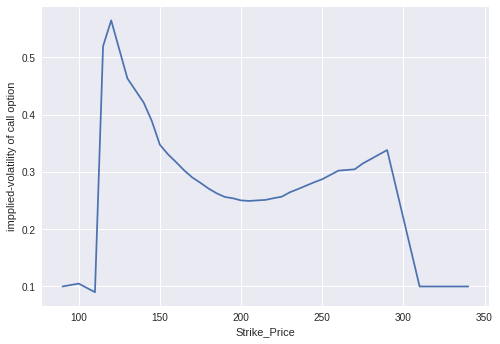

In [0]:
L_rate=2.73263/100.0
today = np.datetime64('2019-02-04')
maturity = np.datetime64('2019-06-21')
time_to_maturity_days = maturity - today
T_1 = time_to_maturity_days/np.timedelta64(1,'D')/365

Init_state=166.52
Drift_ratio=L_rate
maturity=T_1

gbm = GBM(
    init_state = Init_state, #market data
    drift_ratio = Drift_ratio, #market data
    vol_ratio = .1 #initial guess
)

def Clist(Odata):
  Olist=[]
  Slist=[]
  for row in Odata:
    market_price, strike=row
    Slist.append(strike)
    Olist.append(Option(Otype=1,Strike=strike, Maturity=T_1,Market_Price=market_price))
  return Olist, Slist

def targetfunction(sigma, gbm, option):
  gbm.vol_ratio=sigma
  return (GBM.bsm_price(gbm, option)-option.Market_Price)**2

def implied_volatility(gbm, option):
  sigma=0.1
  return float(so.fmin(targetfunction, sigma, args=(gbm, option), disp=0)[0]) 

Olist, Slist=Clist(Odata)
Vlist=[]
for option in Olist:
  Vlist.append(implied_volatility(gbm, option))
plt.figure()
plt.plot(Slist, Vlist)
plt.xlabel('Strike_Price')
plt.ylabel('impplied-volatility of call option')
plt.show()

Now, we will calibrate bsm volatility for the option prices, denote it by $\hat \sigma$. You may use any error function for the calibration purpose.

In [0]:
def erro_function(sigma, gbm, Olist):
  erro=0
  gbm.vol_ratio=sigma
  for option in Olist:
    erro+=(GBM.bsm_price(gbm, option)-option.Market_Price)**2
  return erro

def bsm_calibration(gbm, Olist):
  sigma=0.1
  return float(so.fmin(erro_function, sigma, args=(gbm, Olist), disp=0)[0])
  

In [0]:
sigma_hat=bsm_calibration(gbm, Olist)
sigma_hat

0.2971093750000007

In [0]:
gbm.vol_ratio=sigma_hat
Values=[GBM.bsm_price(gbm, option) for option in Olist]

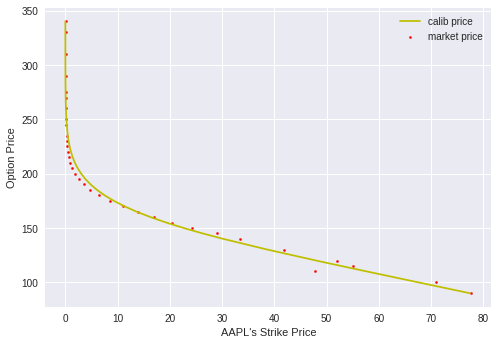

In [0]:
plt.figure()
plt.scatter([option.Market_Price for option in Olist], Slist,color='r',s=5,label='market price')
plt.plot(Values, Slist,color='y',label = 'calib price')
plt.xlabel("AAPL's Strike Price")
plt.ylabel('Option Price')
plt.legend()
plt.show()